In [18]:
# numerical / scientific
import numpy as np
import torch
import gpytorch as gp

# data
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf

# plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 5)

# misc
import datetime
from typing import Tuple
from tqdm import tqdm

# utility  imports
from utilities.processing_utility import get_q_2_cw_data, get_train_test_split
from utilities.plotting_utility import plot_daily, plot_price_and_returns
from utilities.strategy_utilities import get_theta_and_V


# strategies imports
from strategies.ma_mean_reversion import get_ma_mean_reversion_signal
import strategies.gp_mean_reversion as gp_mean_reversion
from strategies.gp_mean_reversion import get_gp_mean_reversion_signal
from strategies.ma_breakout import get_ma_breakout_signal
import strategies.gp_breakout as gp_breakout
from strategies.gp_breakout import get_gp_breakout_signal


In [19]:
df = pd.read_csv('cw_2_data.csv')

In [20]:
# get train test split
split_idx = int(len(df) * 0.7)
risk_free_rate_series = torch.tensor(df['daily_effr'].to_numpy(), dtype=torch.float32)
excess_return_data = torch.tensor(df['daily_excess_returns'].to_numpy(), dtype=torch.float32)
norm_excess_return_data = torch.tensor(df['normalised_excess_returns'].to_numpy(), dtype=torch.float32)
price_data = torch.tensor(df['adjusted_close_price'].to_numpy(), dtype=torch.float32)
x_data = torch.arange(0, len(price_data), dtype=torch.float32)

train_data, test_data = get_train_test_split(splitindex = split_idx, RFR = risk_free_rate_series, daily_R = excess_return_data, norm_R = norm_excess_return_data, P = price_data, X = x_data)

rfr_train, rfr_test = train_data['RFR'], test_data['RFR'] #  risk free rate
daily_r_train, daily_r_test = train_data['daily_R'], test_data['daily_R'] # daily excess returns
norm_r_train, norm_r_test = train_data['norm_R'], test_data['norm_R'] # normalised daily excess returns
p_train, p_test = train_data['P'], test_data['P'] # adjusted closing price
x_train, x_test = train_data['X'], test_data['X'] # x data


In [22]:
class ConstantGP(gp.models.ExactGP):
    """  GP with Linear Mean """
    
    def __init__(self, inputs, targets, likelihood):
        super(ConstantGP, self).__init__(inputs, targets, likelihood)
        self.mean_module = gp.means.constant_mean.ConstantMean()
        self.covar_module = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)
    
    def get_posterior(self, test_inputs, confidenceregion = False):
        self.eval()
        with torch.no_grad(), gp.settings.fast_pred_var():
            f_preds = self(test_inputs)

        if confidenceregion:
            lower, upper = f_preds.confidence_region()
            return f_preds, lower, upper
        
        return f_preds

    def get_posterior_predictive(self, test_inputs, confidenceregion = False):
        # get posterior
        self.eval()
        with torch.no_grad(), gp.settings.fast_pred_var():
            observed_pred = self.likelihood(self(test_inputs))

        if confidenceregion:
            lower, upper = observed_pred.confidence_region()
            return observed_pred, lower, upper
        
        return observed_pred

In [51]:
def get_rsi(P):
    delta = pd.DataFrame({'price' : P}).diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean().fillna(0)
    avg_loss = loss.rolling(window=14).mean().fillna(0)
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(0)

In [55]:
def get_macd(P):
    ema_12 = pd.DataFrame({'price' : P}).ewm(span=12, adjust=False).mean().fillna(0)
    ema_26 = pd.DataFrame({'price' : P}).ewm(span=26, adjust=False).mean().fillna(0)
    macd = ema_12 - ema_26
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd.fillna(0)

In [107]:
macd_train = torch.tensor(get_macd(p_train).to_numpy(), dtype=torch.float32)
rsi_train = torch.tensor(get_rsi(p_train).to_numpy(), dtype=torch.float32)

macd_test = torch.tensor(get_macd(p_test).to_numpy(), dtype=torch.float32)
rsi_test = torch.tensor(get_rsi(p_test).to_numpy(), dtype=torch.float32)

In [108]:
train_data = torch.cat((x_train.unsqueeze(1), macd_train, rsi_train), dim = 1)
test_data = torch.cat((x_test.unsqueeze(1), macd_test, rsi_test), dim = 1)

In [74]:
window_gp = ConstantGP(train_data, p_train, gp.likelihoods.GaussianLikelihood())

window_gp.mean_module.constant = torch.mean(p_train)
window_gp.covar_module.base_kernel.lengthscale = 2.5
window_gp.likelihood.noise = .5

In [76]:
train_data[i]

tensor([24.0000, -1.5916, 33.6323])

In [161]:
def get_gp_breakout_signal(
    X : torch.Tensor,
    P : torch.Tensor,
    lengthscale : float = 2.5,
    noise : float = .5,
    window : int = 20,
    ) -> torch.Tensor:
    """
    Get the signal for a GP cross over strategy.

    Arguments:
    ----------
    X           : {torch.Tensor}
                    > The time series of the data.
    P           : {torch.Tensor}
                    > The time series of the prices.

    Returns:
    ----------
    signal      : {torch.Tensor}
                    > The signal for the GP cross over strategy.
    buy_mask    : {torch.Tensor}
                    > The mask for the buy signal.
    sell_mask   : {torch.Tensor}
    """
    # setp
    buy_mask = torch.zeros_like(P)
    sell_mask = torch.zeros_like(P)

    signal = torch.zeros_like(P)   

    upper_cci, lower_cci = torch.zeros_like(P), torch.zeros_like(P)
    gp_map = torch.zeros_like(P)
    gp_pred = torch.zeros_like(P)

    rolling_std = P.unfold(0, window, 1).std(dim=1)
    signal_weights = (rolling_std / rolling_std.max()) * 0.99

    # sequential prediction
    for i, (x, p) in enumerate(zip(X, P)):     
        
        if i <= window:
            signal[i] = 0
            continue

        # fit a GP to ths historica data
        n_start = i - window
        n_end = i 
        window_gp = ConstantGP(X[n_start:n_end], P[n_start:n_end], gp.likelihoods.GaussianLikelihood())

        window_gp.mean_module.constant = torch.mean(P[n_start:n_end])
        window_gp.covar_module.base_kernel.lengthscale = lengthscale
        window_gp.likelihood.noise = noise

        if i + 1 < len(X):
            f_test = window_gp.get_posterior_predictive(X[n_end+1].view(1,-1), False).mean


        if f_test > p:

            signal[i] = signal_weights[i-window]

        elif f_test < p:

            signal[i] = -signal_weights[i-window]

        else:
            signal[i] = 0

    return signal, buy_mask, sell_mask, gp_map, lower_cci, upper_cci, gp_pred

In [162]:
train_gpbo_s, train_gpbo_bm, train_gpbo_sm, train_map, train_lower_cci, train_upper_cci, train_pred = get_gp_breakout_signal(train_data, p_train, lengthscale=12, noise=5, window=80)
test_gpbo_s, test_gpbo_bm, test_gpbo_sm, test_map, test_lower_cci, test_upper_cci, test_pred = get_gp_breakout_signal(x_test, p_test, lengthscale=12, noise=5, window=80)

In [143]:
bo_lengthscale_hat, bo_noise_hat = gp_breakout.optimise_marginal_likelihood(train_data, p_train, 1000)

       Iteration        |          Loss          |      Lengthscale       |         Noise          
          100           |   693.1717529296875    |        5.68901         |        2.98020         
----------------------------------------------------------------------------------------------------


KeyboardInterrupt: 

In [111]:
# make tensor grid for window, lengthscale, and noise
window_grid = torch.linspace(10, 100, 10)
lengthscale_grid = torch.linspace(1, 10, 10)
noise_grid = torch.linspace(.1, 1, 10)

X, Y, Z = torch.meshgrid(window_grid, lengthscale_grid, noise_grid)


In [114]:
len(X.ravel())

1000

In [120]:
for W in range(50, 100,2 ):
    signal, buy_mask, sell_mask, gp_map, lower_cci, upper_cci, gp_pred = get_gp_breakout_signal(
        test_data, p_test, lengthscale = 15, noise = 5, window = W
    )
    test_gpbo_strat = get_theta_and_V(daily_r_test, rfr_test , signal, initial_cash = 200_000., leverage = 5.)

    if W % 10 == 0:
        print('Iteration {}'.format(W))
    
    if test_gpbo_strat['V_total'][-2] > 200_000:
        print(f"window: {W}, signal: {signal.sum()}, V_total: {test_gpbo_strat['V_total'][-2]}")


Iteration 50
window: 50, signal: -204.0, V_total: 221133.1341642643
window: 52, signal: -202.0, V_total: 273033.35621262435
window: 54, signal: -202.0, V_total: 314801.00461428135
window: 56, signal: -200.0, V_total: 334153.8486240189
window: 58, signal: -198.0, V_total: 274802.9800582168
Iteration 60
window: 60, signal: -198.0, V_total: 281741.0973411015
window: 62, signal: -196.0, V_total: 383893.08511315484
window: 64, signal: -198.0, V_total: 332921.380791
window: 66, signal: -196.0, V_total: 323143.88438879023
window: 68, signal: -194.0, V_total: 315828.3738713595
Iteration 70
window: 70, signal: -192.0, V_total: 319307.6168499124
window: 72, signal: -188.0, V_total: 311209.2687794157
window: 74, signal: -184.0, V_total: 337688.2236348985
window: 76, signal: -182.0, V_total: 335212.3524558708
window: 78, signal: -178.0, V_total: 426948.1967693817
Iteration 80
window: 80, signal: -180.0, V_total: 635486.9511053014
window: 82, signal: -180.0, V_total: 516967.3320158409
window: 84, s

In [154]:
train_gpbo_s, train_gpbo_bm, train_gpbo_sm, train_map, train_lower_cci, train_upper_cci, train_pred = get_gp_breakout_signal(train_data, p_train, lengthscale=12, noise=5, window=80)
test_gpbo_s, test_gpbo_bm, test_gpbo_sm, test_map, test_lower_cci, test_upper_cci, test_pred = get_gp_breakout_signal(x_test, p_test, lengthscale=12, noise=5, window=80)

IndexError: index 977 is out of bounds for dimension 0 with size 977

In [163]:
train_gpbo_strat = get_theta_and_V(daily_r_train, rfr_train , train_gpbo_s, initial_cash = 200_000., leverage = 5.)
test_gpbo_strat = get_theta_and_V(daily_r_test, rfr_test , test_gpbo_s, initial_cash = 200_000., leverage = 5.)

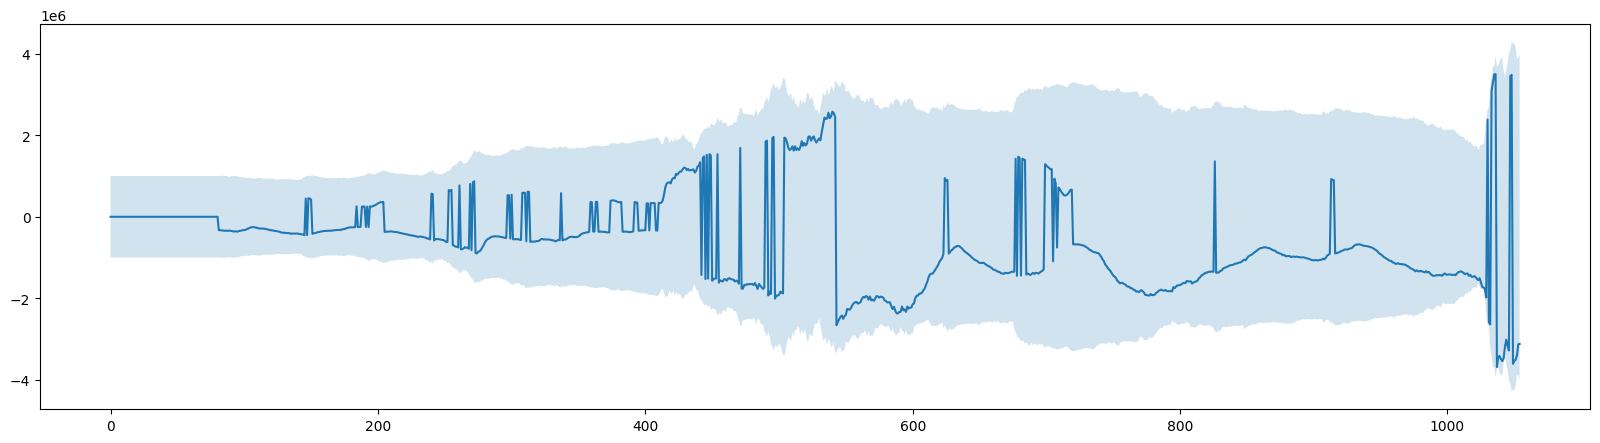

In [164]:
plt.plot(x_train[:-1], train_gpbo_strat['theta'][:-1])
plt.fill_between(x_train[:-1], 5*train_gpbo_strat['V_t'][:-1], -5*train_gpbo_strat['V_t'][:-1], alpha=0.2)

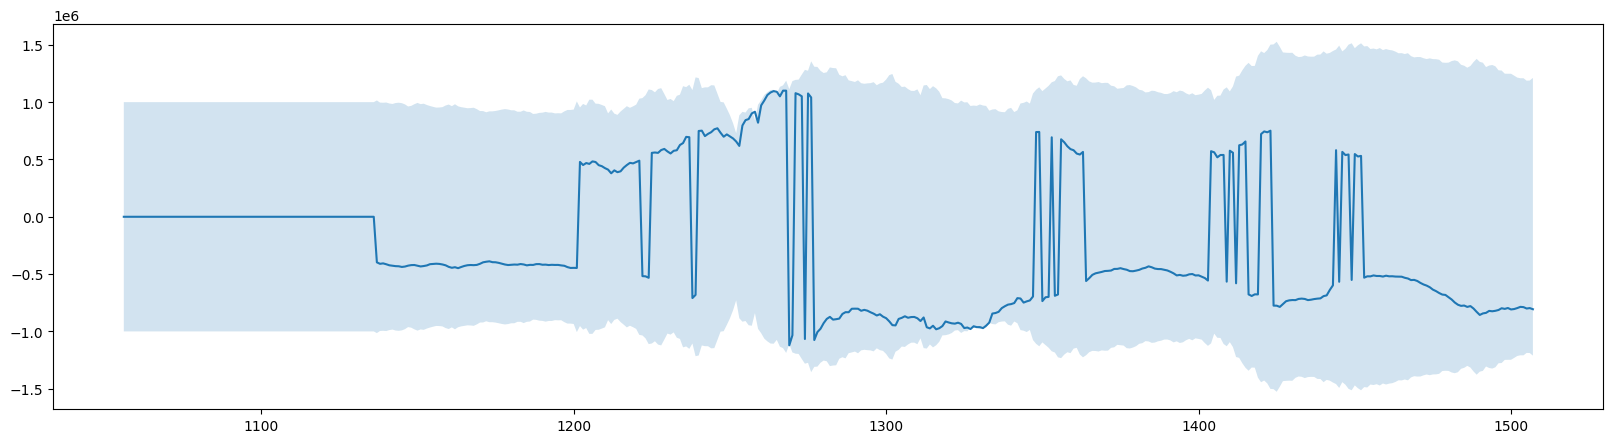

In [165]:
plt.plot(x_test[:-1], test_gpbo_strat['theta'][:-1])
plt.fill_between(x_test[:-1], 5*test_gpbo_strat['V_t'][:-1], -5*test_gpbo_strat['V_t'][:-1], alpha=0.2)

In [ ]:
ma = window[i-window:i].sum() / window
upper_bound = ma + (2 * window[i-window:i].std())
lower_bound = ma - (2 * window[i-window:i].std())